## Análise exploratória dos dados
<hr style="border:2px solid #0077b9;">

- Leitura de dados: Geopandas e WTSS
- Explorando os dados ([seaborn](https://seaborn.pydata.org/))


# 1. Leitura de dados
## 1.1 Dados Vetoriais (Geopandas)

In [1]:
import geopandas

dados = geopandas.read_file("dados/focos/focos.shp")

In [2]:
dados.head()

,FOCOS_ID,REGIAO,BIOMA,TIMESTAMP,geometry
0,37646641.0,CO,Pantanal,2016-08-05 17:20:00,POINT (-55.696 -16.596)
1,37646697.0,CO,Pantanal,2016-08-05 13:33:33,POINT (-55.697 -16.6)
2,37646739.0,CO,Pantanal,2016-08-05 17:20:00,POINT (-56.122 -16.417)
3,37646747.0,CO,Pantanal,2016-08-05 17:20:00,POINT (-56.128 -16.425)
4,37646779.0,CO,Pantanal,2016-08-06 17:00:00,POINT (-56.174 -16.45)


## 1.2 Dados Raster (WTSS)

In [3]:
from wtss import wtss
w = wtss("http://www.esensing.dpi.inpe.br")

cv_list = w.list_coverages()
for c in cv_list['coverages']:
    print(c)

MOD13Q1
MOD13Q1_M


In [4]:
cv_scheme = w.describe_coverage("MOD13Q1")
attrs = [k for k in cv_scheme["attributes"]]

print("Name: {}".format(cv_scheme["name"]))
print("Description: {}".format(cv_scheme["description"]))
print("Timeline: {} ... {}".format(cv_scheme["timeline"][0:2], cv_scheme["timeline"][-3:-1]))
print("Attributes: {}".format(attrs))

Name: MOD13Q1
Description: Vegetation Indices 16-Day L3 Global 250m
Timeline: ['2000-02-18', '2000-03-05'] ... ['2018-05-25', '2018-06-10']
Attributes: ['mir', 'blue', 'nir', 'red', 'evi', 'ndvi']


# 1.3 Obtendo dados Raster

In [5]:
ts = w.time_series("MOD13Q1", attrs, -16.596, -55.696, "2018-05-25", "2018-06-25")
print("red: {}".format(ts["red"]))
print("blue: {}".format(ts["blue"]))
print("ndvi: {}".format(ts["ndvi"]))
print("Timeline: {}".format(ts.timeline))

red: [651.0, 713.0]
blue: [288.0, 327.0]
ndvi: [5870.0, 5925.0]
Timeline: [datetime.date(2018, 5, 25), datetime.date(2018, 6, 10)]


# Análise

In [6]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib
import pickle
import matplotlib.pyplot as plt
from IPython.display import display, HTML 
%matplotlib inline 

In [7]:
# Carregando dados previamente salvos

# Risco, Temperatura, Umidade, Precipitação
dados = pd.read_pickle('dados/dados.pkl')

## Entendendo os dados

In [8]:
dados.groupby("regiao").size()

regiao
CO    500
N     500
NE    500
S     500
SE    500
dtype: int64

In [9]:
dados.groupby("bioma").size()

bioma
Amazônia          622
Caatinga          144
Cerrado           871
Mata Atlântica    717
Pampa              81
Pantanal           65
dtype: int64

In [10]:
dados.sample(n=5) 

,humidity,precipitation,risk,temperature,bioma,regiao,timestamp
2019,0.582498,4.891221,0.023614,300.278168,Mata Atlântica,S,2016-04-01T17:47:42Z
979,0.228301,0.000000,1.000000,306.610321,Cerrado,NE,2016-09-07T04:25:00Z
424,0.701274,1.399837,0.357858,302.000092,Amazônia,N,2016-01-13T16:52:10Z
1455,0.245322,0.000000,1.000000,304.399719,Pantanal,CO,2016-09-26T17:34:02Z
1067,0.500713,0.000000,0.780187,298.835419,Amazônia,CO,2016-09-04T17:55:00Z


## Explorando os dados
<hr style="border:2px solid #0077b9;">
- Explorar dados
    - Todo o Brasil
    - Por região (N, NE, CO, SE e S)
    - Por bioma (Amazônia, Caatinga, Cerrado, Pantanal, Mata Atlântica e Pampa)
    - Por estação (Primavera, Verão, Outono e Inverno)

### Todo o Brasil
<hr style="border:2px solid #0077b9;">

In [11]:
# Visão geral dos dados
dados.describe()

,humidity,precipitation,risk,temperature
count,2500.000000,2500.000000,2.500000e+03,2500.000000
mean,0.393418,0.240373,2.193226e+35,303.259091
std,0.168406,1.349106,1.462609e+36,5.183475
min,0.112702,0.000000,3.000701e-07,281.210266
25%,0.263692,0.000000,6.098014e-01,300.751740
50%,0.359624,0.000000,1.000000e+00,304.640213
75%,0.489772,0.000000,1.000000e+00,306.974297
max,0.990000,19.725483,9.969210e+36,313.932220


In [12]:
# Arrumando os dados

# Removendo linhas com missing data
dados = dados[dados['risk']<=1]

# reordenando os dados
dados = dados[["risk", "precipitation", "humidity", "temperature", "bioma", "regiao", "timestamp"]]

# Convertendo temperatura de Kelvin para Celsius
dados["temperature"] = dados["temperature"]-273.15

# Convertendo para data
dados['timestamp'] = pd.to_datetime(dados['timestamp'])  

dados.describe()

,risk,precipitation,humidity,temperature
count,2.445000e+03,2445.000000,2445.000000,2445.000000
mean,7.832390e-01,0.240514,0.389986,30.203471
std,3.354363e-01,1.354300,0.166902,5.165241
min,3.000701e-07,0.000000,0.112702,8.060266
25%,5.830897e-01,0.000000,0.262603,27.765741
50%,1.000000e+00,0.000000,0.355428,31.578058
75%,1.000000e+00,0.000000,0.484281,33.872186
max,1.000000e+00,19.725483,0.990000,40.782220


In [13]:
# importando e configurando módulos de plotagem

fig_size = (16,5)
# palette=sns.diverging_palette(10, 240,  as_cmap=True)

siglas = ["N ", "NE", "CO", "SE", "S "]
titulos = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]

palette=sns.diverging_palette(240, 10,  as_cmap=True)

# Configurando slides
#from traitlets.config.manager import BaseJSONConfigManager
#path = "/home/vconrado/anaconda3/envs/ds/etc/jupyter/nbconfig"
#cm = BaseJSONConfigManager(config_dir=path)
#cm.update("livereveal", {
#              "scroll": True,
#              "start_slideshow_at": "selected",
# })

(4.0, 0)

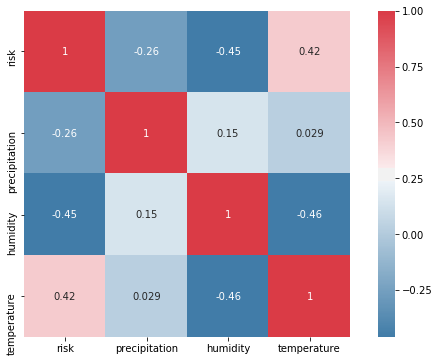

In [14]:
# Gerando matrix de correlação
f, ax = plt.subplots(figsize=(10, 6))
corr = dados.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
            square=True, ax=ax, annot=True)
ax.set_ylim(4.0, 0)

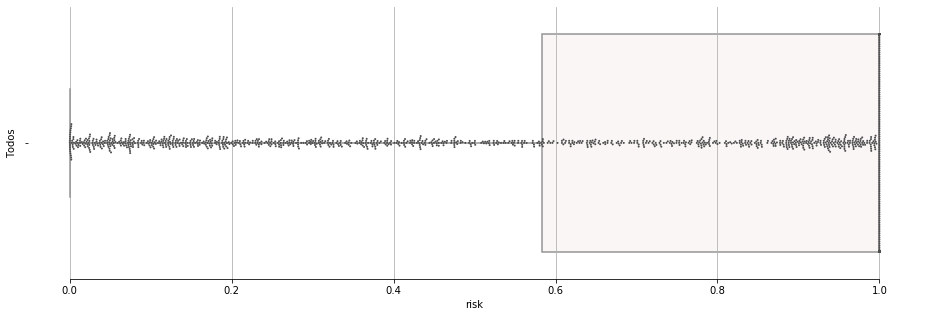

In [15]:
# Boxplot de todos os dados
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", data=dados, palette="vlag")
sns.swarmplot(x="risk", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True) 
ax.set(ylabel="Todos")
sns.despine(trim=True, left=True)

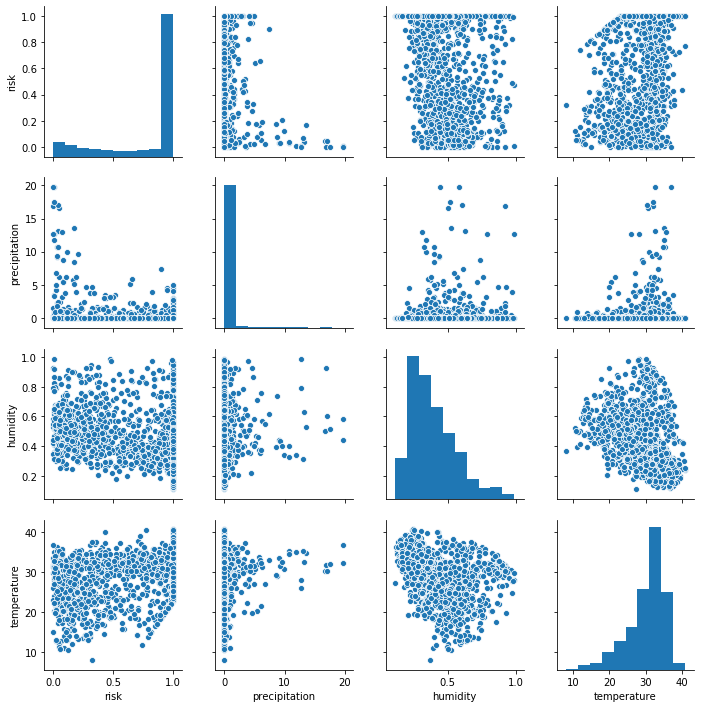

In [16]:
# Gerando scatterplot matrix
sns.pairplot(dados)

### Por região
<hr style="border:2px solid #0077b9;">
- N, NE, CO, SE e S

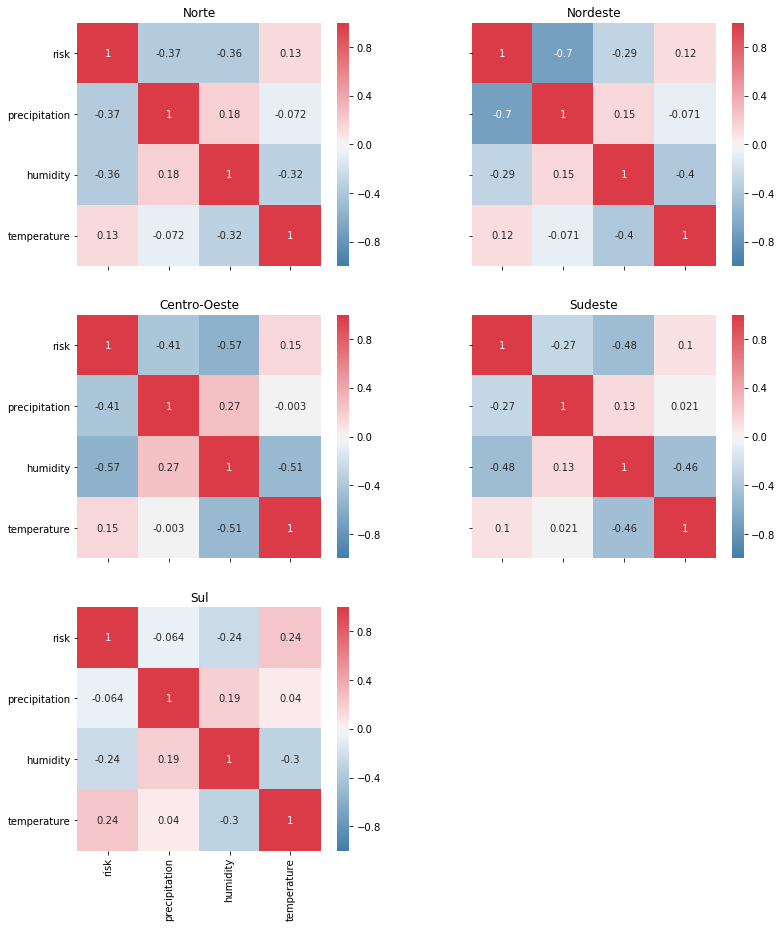

In [17]:
# Gerando matrix de correlação para cada região

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(0, 5):
    corr = dados[dados['regiao'] == siglas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
                square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(titulos[i])
    ax[i].set_ylim(4.0, 0)


ax6.set_visible(False)
plt.subplots_adjust(hspace=0.2, top=3, right=1.8)

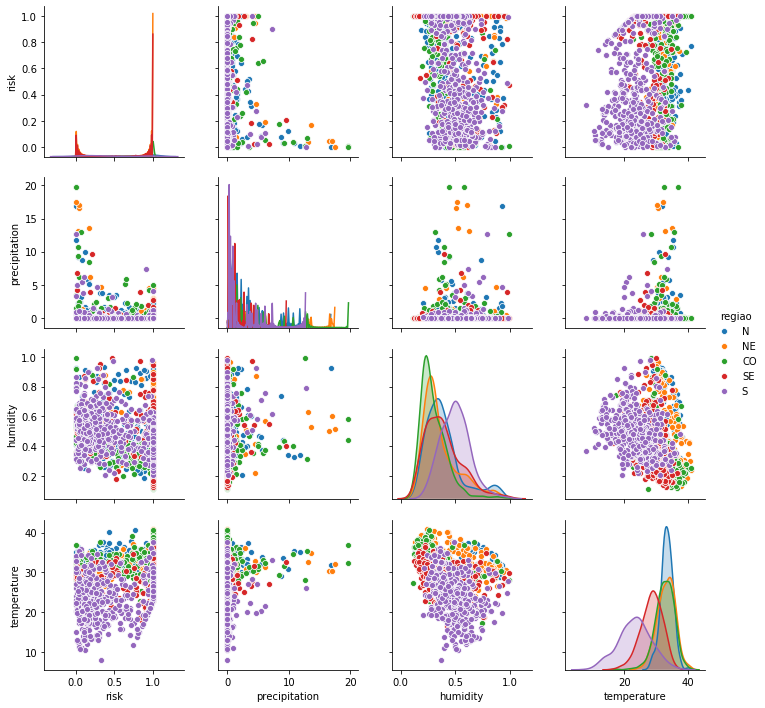

In [18]:
# Gerando scatterplot matrix por região
sns.pairplot(dados, hue="regiao")

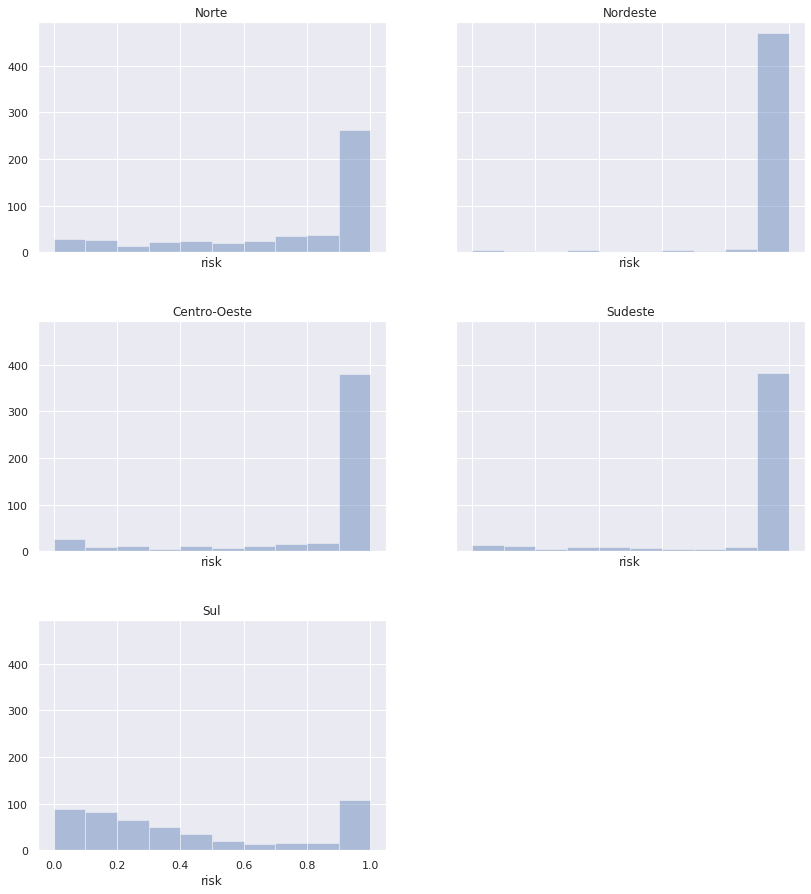

In [19]:
# Histogramas para cada região
from scipy import stats, integrate
sns.set(color_codes=True)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(0, 5):
    sns.distplot(dados[dados['regiao'] == siglas[i]]["risk"], ax=ax[i], kde=False, bins=10);
    ax[i].set_title(titulos[i])

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.3, top=3, right=1.9)

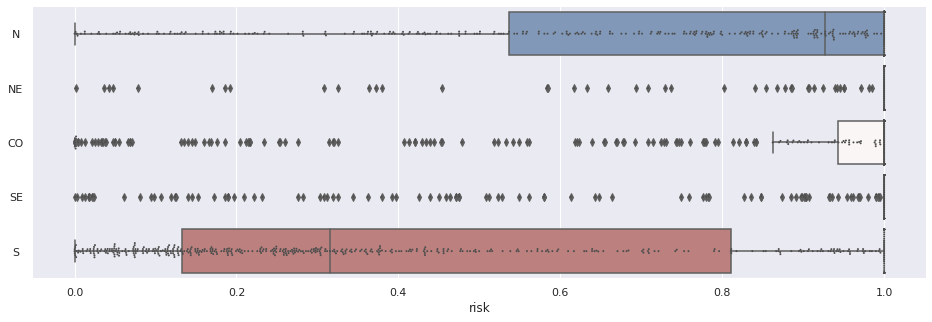

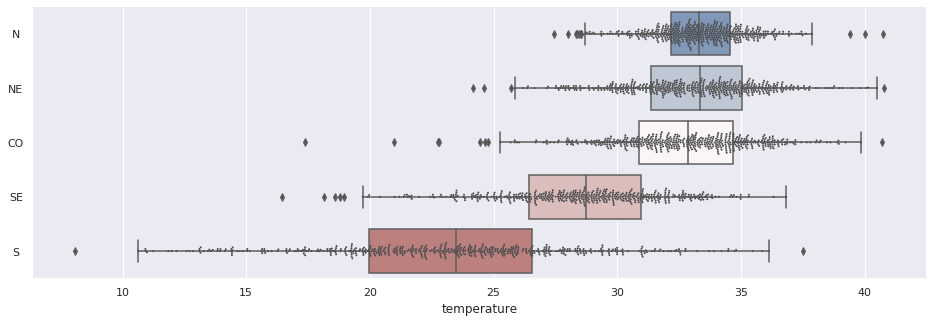

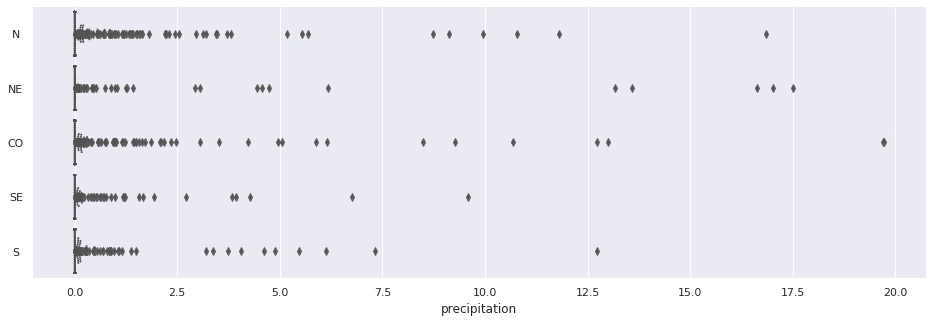

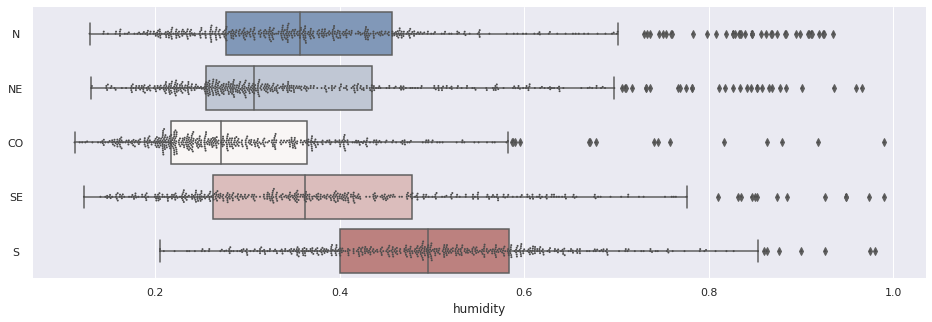

In [20]:
# Gerando boxplot para (risco, temperatura, precipitação, umidade) por região

for var in ("risk", "temperature", "precipitation", "humidity"):
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(ax=ax, x=var,  y="regiao", data=dados, palette="vlag")
    sns.swarmplot(x=var, y="regiao", data=dados, size=2, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_ylim(4.5, -0.5)

### Por bioma
<hr style="border:2px solid #0077b9;">
- Amazônia, Caatinga, Cerrado, Pantanal, Mata Atlântica e Pampa

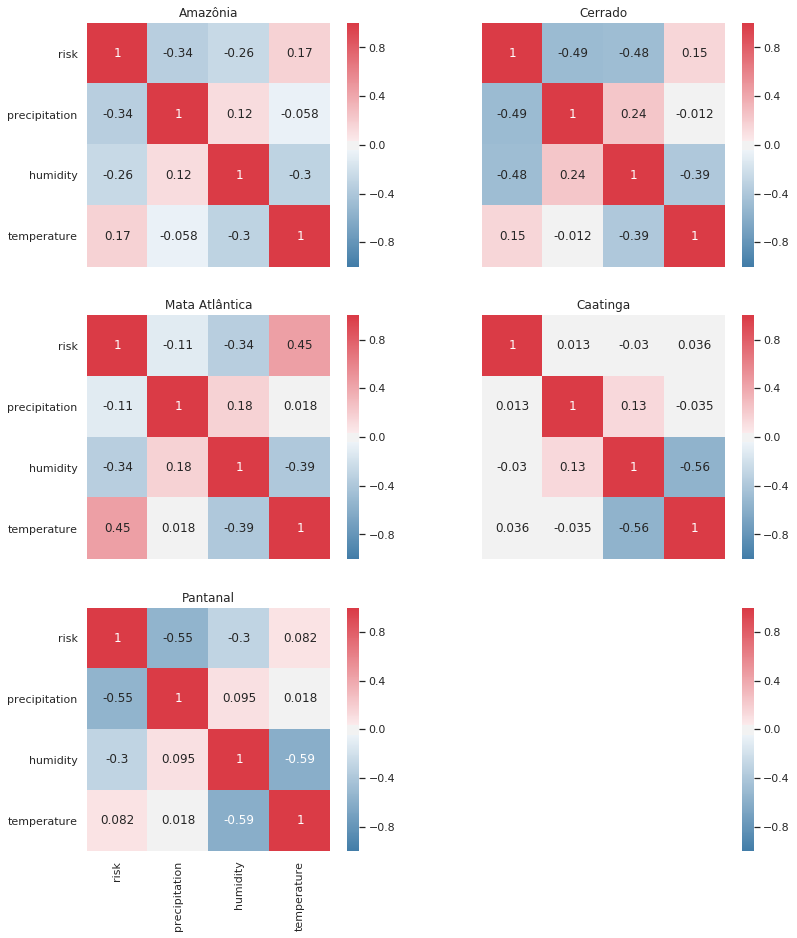

In [21]:
biomas = dados['bioma'].unique()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(0, 6):
    corr = dados[dados['bioma']==biomas[i]].corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=palette, 
                square=True, ax=ax[i], annot=True, vmin=-1, vmax=1)
    ax[i].set_title(biomas[i])
    ax[i].set_ylim(4.0, 0)

ax6.set_visible(False)
plt.subplots_adjust(hspace=0.2, top=3, right=1.8)

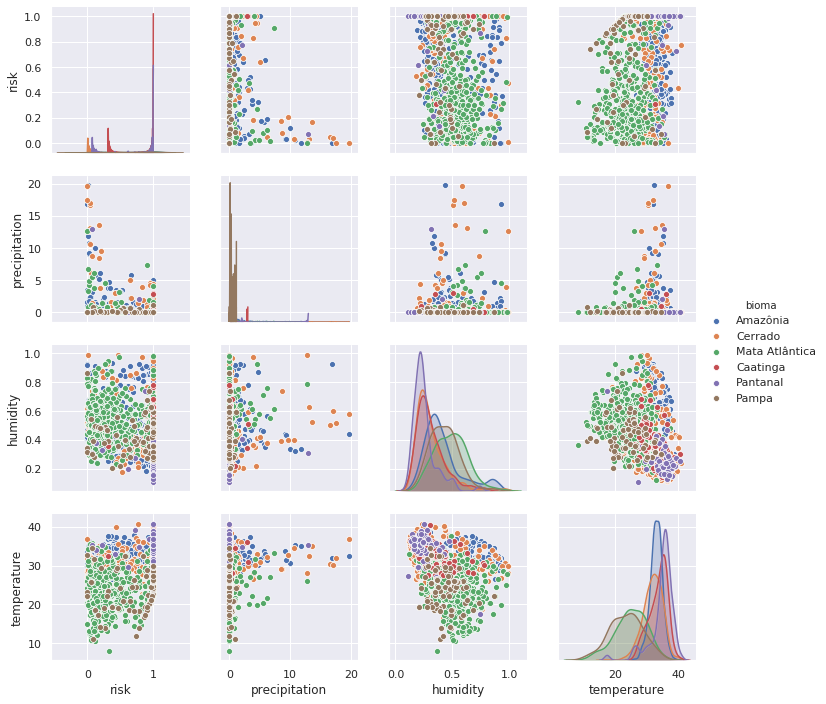

In [22]:
# Gerando scatterplot matrix por bioma
sns.pairplot(dados, hue="bioma")

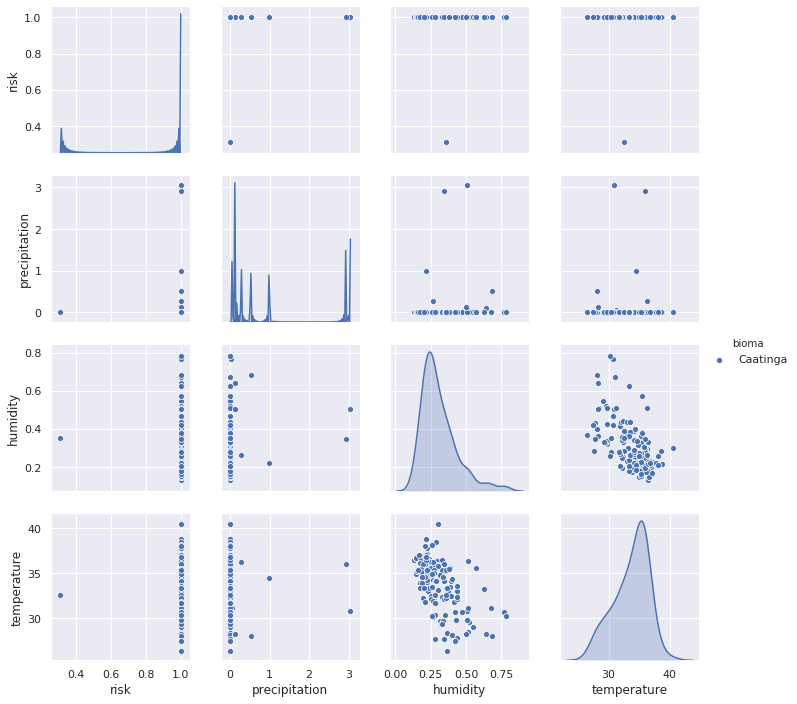

In [23]:
# Olhando os dados da Caatinga
sns.pairplot(dados[dados['bioma']=="Caatinga"], hue="bioma")

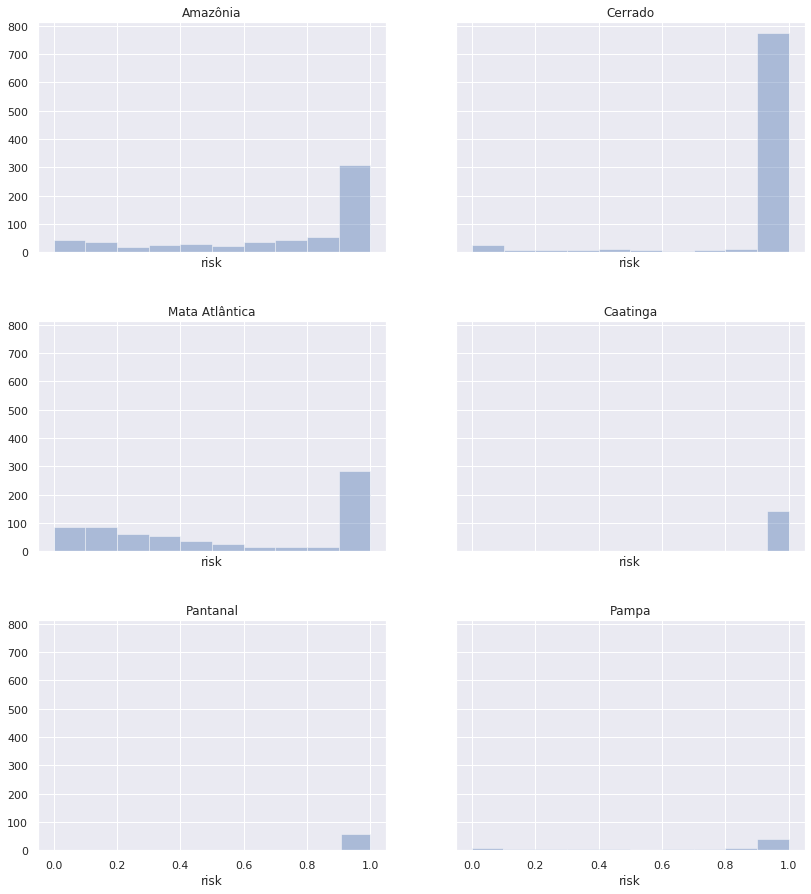

In [24]:
# Histogramas para cada região

from scipy import stats, integrate
sns.set(color_codes=True)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2 , sharex=True, sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(0, 6):
    sns.distplot(dados[dados['bioma']==biomas[i]]["risk"], ax=ax[i], kde=False, rug=False, bins=10);
    ax[i].set_title(biomas[i])

plt.subplots_adjust(hspace=0.3, top=3, right=1.9)

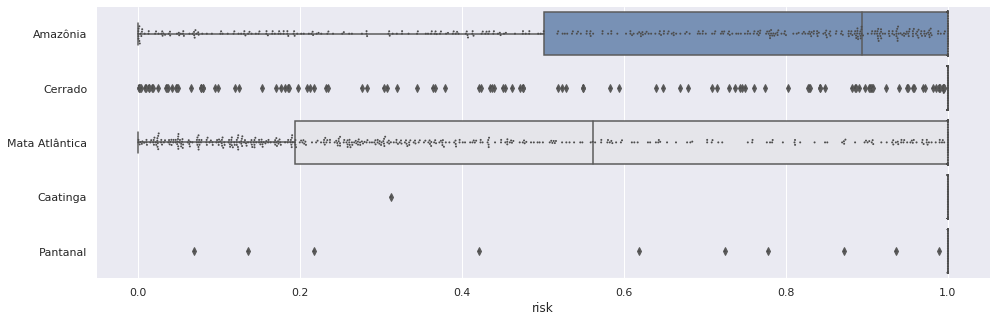

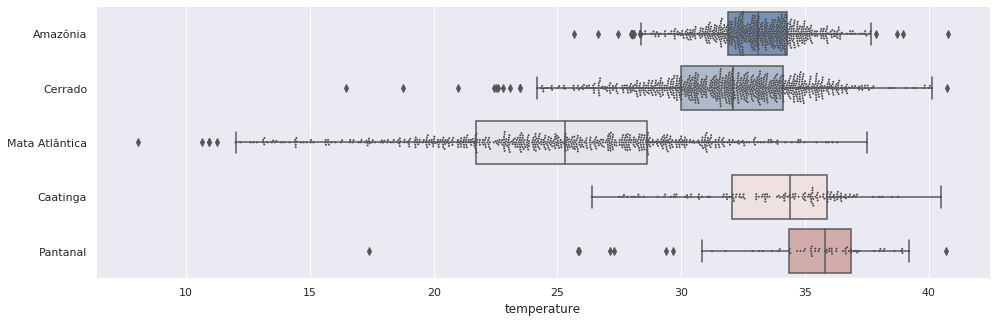

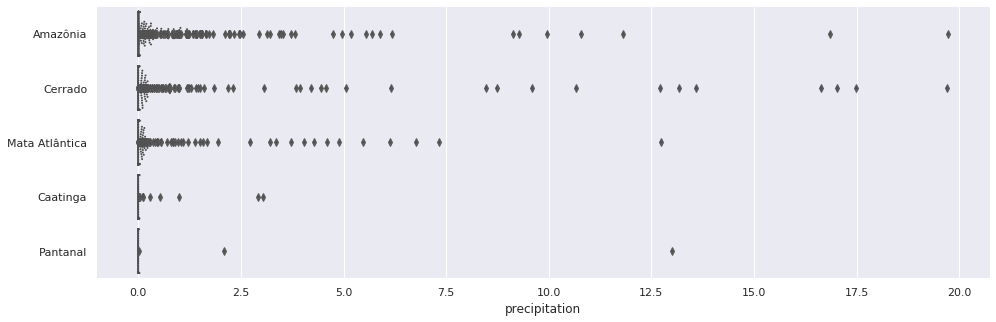

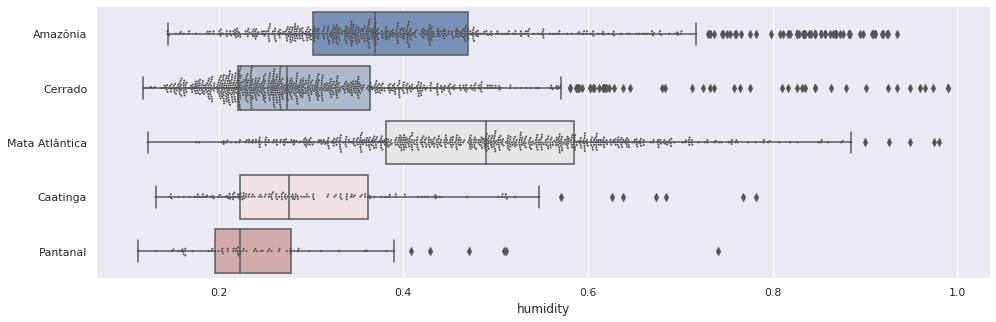

In [25]:
# Gerando boxplot para (risco, temperatura, precipitação, umidade) por bioma

for var in ("risk", "temperature", "precipitation", "humidity"):
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(ax=ax, x=var, y="bioma", data=dados, palette="vlag")
    sns.swarmplot(x=var, y="bioma", data=dados, size=2, color=".3", linewidth=0)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_ylim(4.5, -0.5)

### Por estações
<hr style="border:2px solid #0077b9;">
- Primavera, Verão, Outono e Inverno

In [26]:
# Separando dados por estação

# períodos das estacoes no hemisfério sul
primavera = (dados['timestamp'] > '2016-09-23') & (dados['timestamp'] <= '2016-12-21')
verao = (dados['timestamp'] > '2016-12-21') | ( (dados['timestamp'] >= '2016-01-01') & (dados['timestamp'] < '2016-03-21') )
outono = (dados['timestamp'] > '2016-03-21') & (dados['timestamp'] <= '2016-06-20')
inverno = (dados['timestamp'] > '2016-06-20') & (dados['timestamp'] <= '2016-09-23')

# Criando coluna estacao
dados['estacao']=''
dados.loc[primavera, 'estacao']="primavera"
dados.loc[verao, 'estacao']="verao"
dados.loc[outono,'estacao']="outono"
dados.loc[inverno, 'estacao']='inverno'

# Contado por grupo de risco e por estação
dados.filter(items=["risk", "estacao"])\
     .groupby(["estacao",pd.cut(dados["risk"], np.arange(0, 1+.25, .25))])\
     .count().rename(columns={'risk':'Total'})

Total
estacao   risk              
inverno   (0.0, 0.25]    143
          (0.25, 0.5]     88
          (0.5, 0.75]     76
          (0.75, 1.0]   1066
outono    (0.0, 0.25]     32
          (0.25, 0.5]     31
          (0.5, 0.75]     13
          (0.75, 1.0]     82
primavera (0.0, 0.25]    124
          (0.25, 0.5]     81
          (0.5, 0.75]     49
          (0.75, 1.0]    514
verao     (0.0, 0.25]     47
          (0.25, 0.5]     17
          (0.5, 0.75]     12
          (0.75, 1.0]     70

(4.5, -0.5)

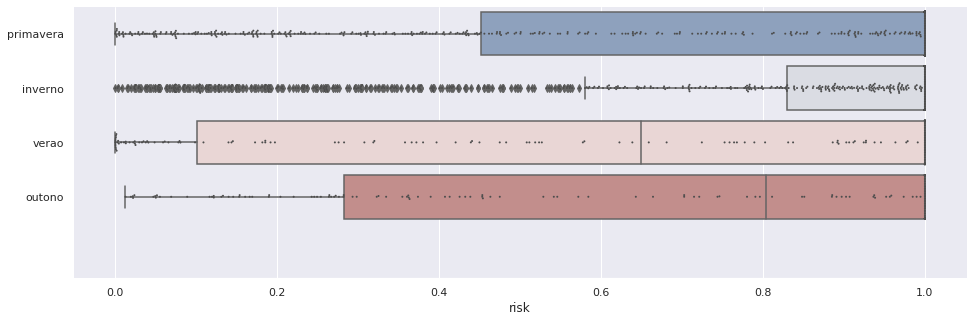

In [27]:
# Boxplot para Estação-Risco
fig, ax = plt.subplots(figsize=fig_size)
sns.boxplot(ax=ax, x="risk", y="estacao", data=dados, palette="vlag")
sns.swarmplot(x="risk", y="estacao", data=dados, size=2, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
ax.set_ylim(4.5, -0.5)

In [28]:
# Ocorrências por Região-Estação

estacao_regiao=pd.DataFrame(index=("N ", "NE", "CO", "SE", "S "))
for estacao in ("primavera", "verao", "outono", "inverno"): 
    for regiao in ("N ", "NE", "CO", "SE", "S "):
        estacao_regiao.loc[regiao,estacao] = len(dados.loc[ (dados['estacao']==estacao) & (dados['regiao']==regiao)])

(5, 0)

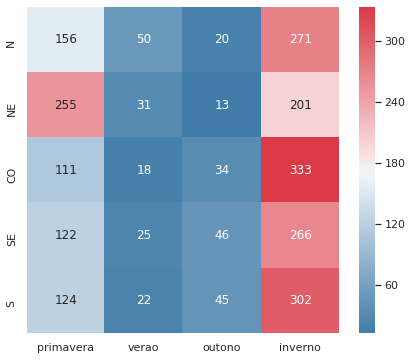

In [29]:
# Heatmap Região-Estação
f, ax = plt.subplots(figsize=(7, 6))        
sns.heatmap(estacao_regiao, cmap=palette, annot=True,  fmt='g', ax=ax)
ax.set_ylim(5, 0)

In [30]:
# Ocorrências por Bioma-Estação

estacao_bioma=pd.DataFrame(index=dados['bioma'].unique())
for estacao in ("primavera", "verao", "outono", "inverno"): 
    for bioma in dados['bioma'].unique():
        #estacao_bioma.set_value(bioma,estacao, len(dados.loc[ (dados['estacao']==estacao) & (dados['bioma']==bioma)]))
        estacao_bioma.loc[bioma,estacao] = len(dados.loc[ (dados['estacao']==estacao) & (dados['bioma']==bioma)])


(5, 0)

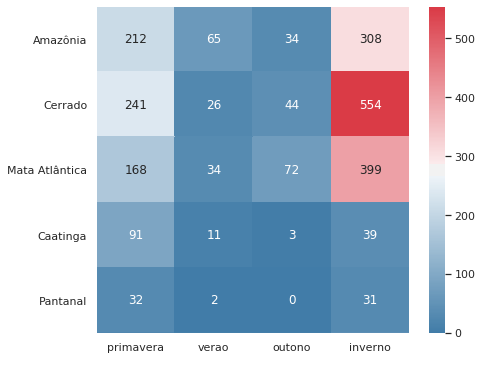

In [31]:
f, ax = plt.subplots(figsize=(7, 6))        
sns.heatmap(estacao_bioma, cmap=palette, annot=True, fmt='g', ax=ax)
ax.set_ylim(5, 0)

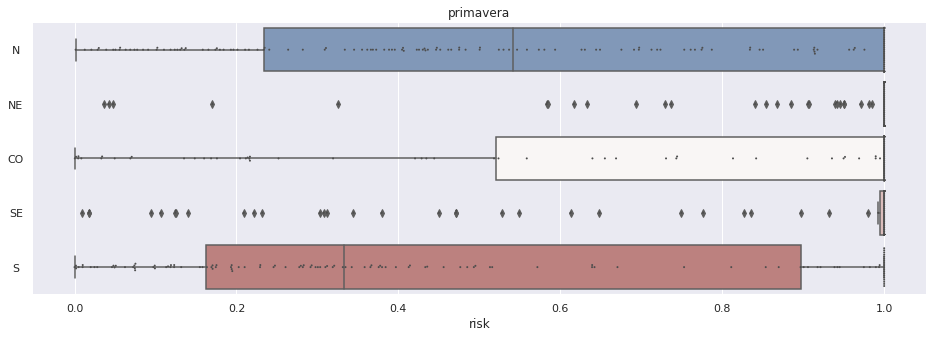

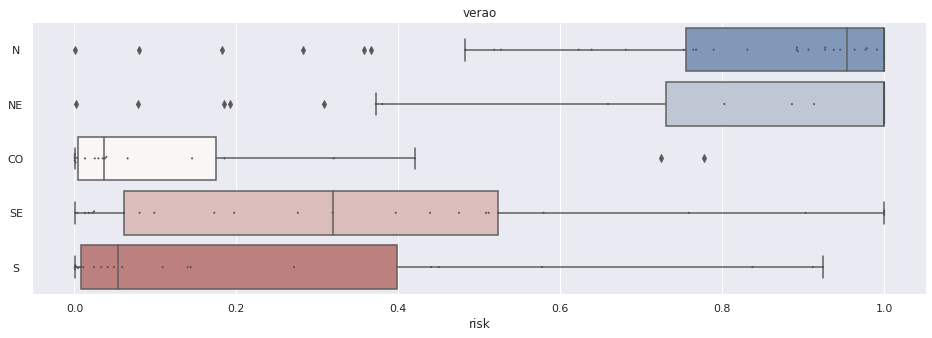

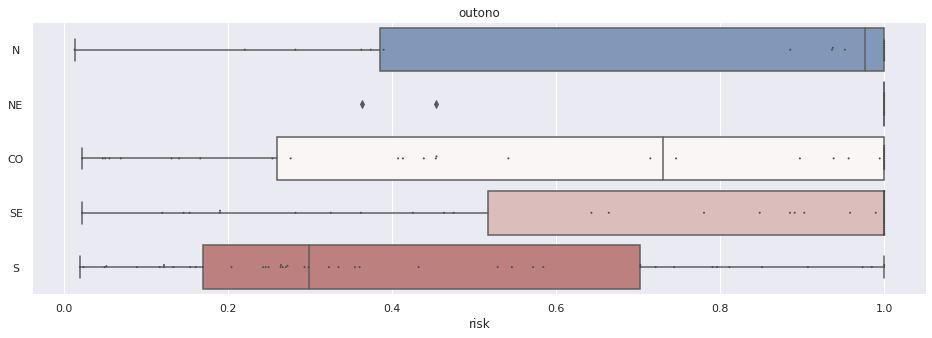

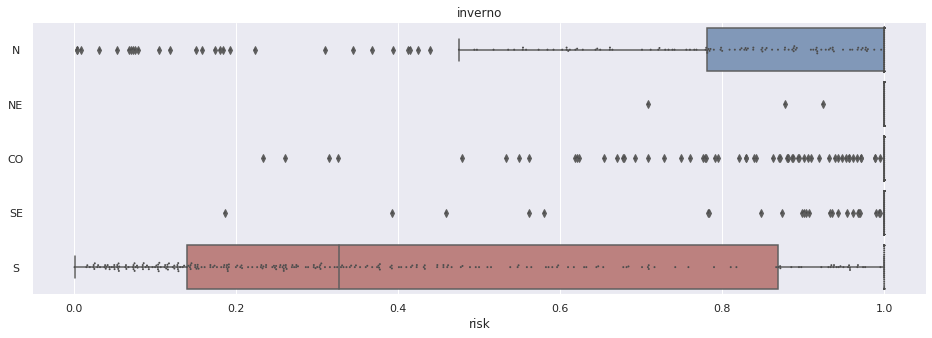

In [32]:
# Boxplot Região-Estação

for estacao,i in zip(("primavera", "verao", "outono", "inverno"), range(0,5)): 
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao] , palette="vlag", ax=ax)
    sns.swarmplot(x="risk", y="regiao", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_title(estacao)
    ax.set_ylim(4.5, -0.5)


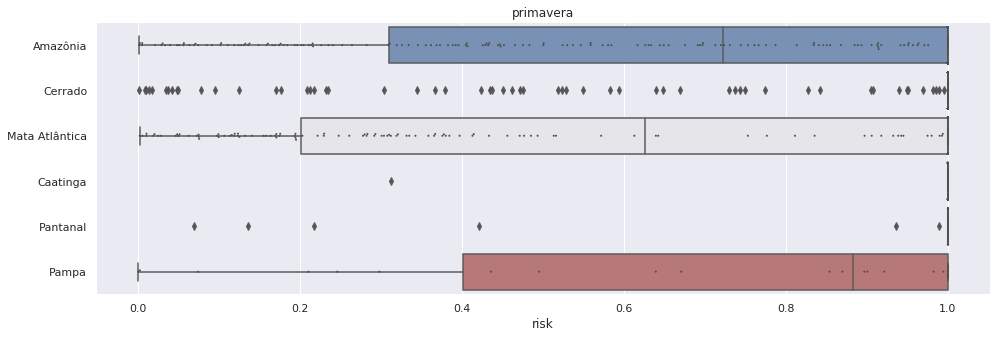

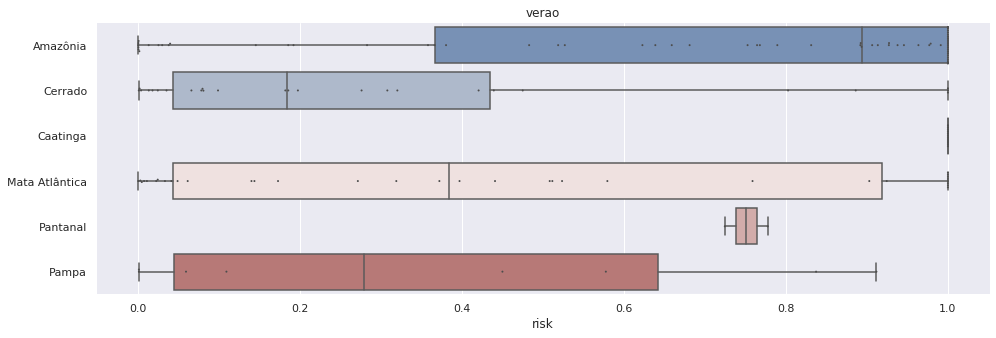

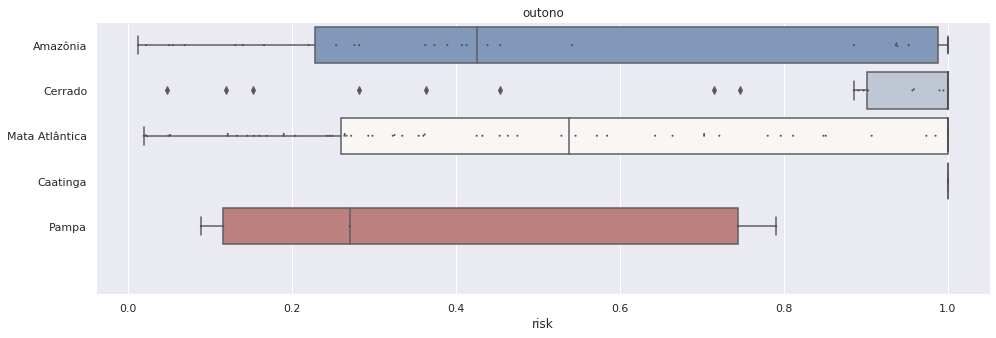

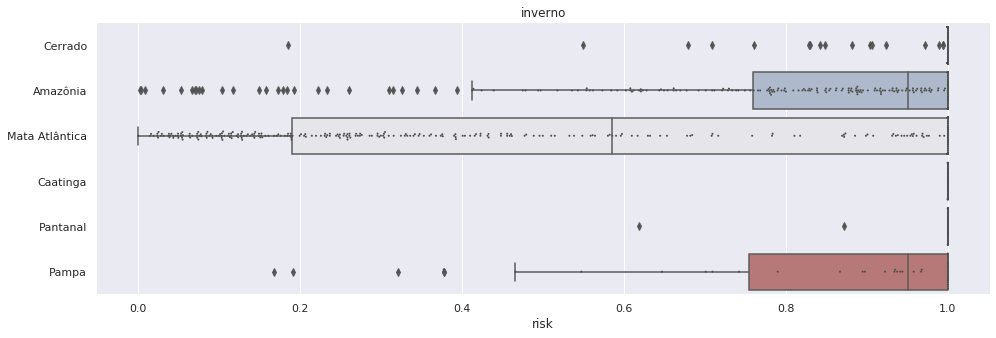

In [33]:
# Boxplot Bioma-Estação

for estacao,i in zip(("primavera", "verao", "outono", "inverno"), range(0,5)): 
    fig, ax = plt.subplots(figsize=fig_size)
    sns.boxplot(x="risk", y="bioma", data=dados.loc[dados['estacao']==estacao] , palette="vlag", ax=ax)
    sns.swarmplot(x="risk", y="bioma", data=dados.loc[dados['estacao']==estacao], size=2, color=".3", linewidth=0, ax=ax)
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    ax.set_title(estacao)
    ax.set_ylim(5.5, -0.5)


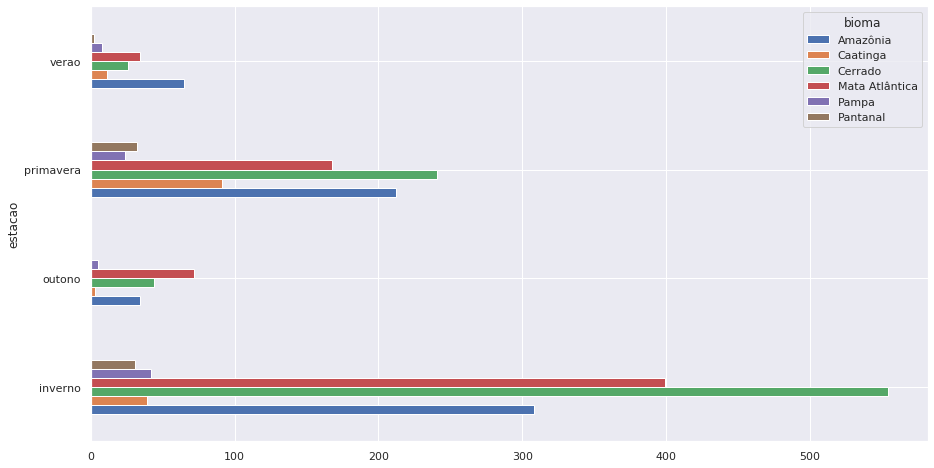

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
dados.groupby("bioma")["estacao"].value_counts().unstack(0).plot.barh(ax=ax)

## Considerações
<hr style="border:2px solid #0077b9;">

### Quanto à análise dos dados
<hr style="border:2px solid #0077b9;">

- **Para uma melhor análise, deve-se considerar situações de risco alto e sem ocorrência de foco;**
- **Amostragem foi feita por região;**
- A relação entre o risco e o foco de queimada não é homogênea nas regiões, biomas ou estações do ano;
- Por região, o índice aparentemente funciona melhor para NE, CO e SE;
- Por bioma, o índice aparentemente funciona melhor para Cerrado, Caatinga e Pantanal;
    - Coerente regiões vs Bioma
- Por estação, o índice aparentemente funciona melhor no Inverno